# <center>Data Science Project Part 2:  Fairness </center>
<center>DATA 558, Spring 2021</center>
<center>TAs: Alec Greaves-Tunnell and Ronak Mehta</center>


## Instructions

Welcome back to the DATA 558 project! Let's begin with a brief reminder of the format: each week, you will receive a notebook containing a data analysis involving the Animals with Attributes 2 (AwA2) dataset. The notebook will claim to meet some statistical or machine learning criterion relevant to the week's lecture topic. Your goal is to investigate and critique this analysis.

__Objective__: This notebook claims to implement a new method for classification of the AwA2 animals that is fair with respect to a given attribute. There are no mistakes in the syntax; each cell runs and returns a plausible result. However, there are several mistakes from a statistical and conceptual perspective. Working with your partner, you are expected to provide (1) a list of these mistakes and (2) a justification for why each item you list in (1) is a mistake. Justification can take many forms, including but not limited to a __detailed comment__, a __code example showing the problem__, or (perhaps simplest in some cases) a __direct fix of the code and demonstration that the problem is resolved__.


__Deliverable__: Please submit to Gradescope __a copy of this notebook with your findings and comments__. Please use the cell below to summarize the mistakes you found. That is, for each mistake, write a (short) indication of what the mistake is and where you found it. For every item in this summary, you are expected to provide a matching justification in the notebook with the same label - e.g. for mistake `A`, include in the notebook a justification (again, this may be a comment, code block, etc.) at the location where this mistake is made, also labeled `A`.



#### Name: Apoorv Sharma
#### Partner: Leena Elamrawy	
#### Summary of findings:

    A: The `FairClassifier` is being evaluated on the training set. It should be evaluated on the test set. 

    B: Equal Odds fariness criterion fails for the `FairClassifier`
    
    C: The testset should be used to predict the performance of the model for `DefinitelyFairModel`
    
    D: Use of `balanced_accuracy_score` instead of `r2_score`
    
    E: `FairClassifier` is an unfair classifier
    
    F: `DefinitelyFairClassifier` is a more fair model 

In [99]:
import copy
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, plot_roc_curve, roc_auc_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from fairlearn.metrics import equalized_odds_difference, demographic_parity_difference

## Dataset: Animals with Attributes v2

The data consists of $n=5000$ examples from the `Animals with Attributes 2` dataset. In particular we have:

- $X \in \mathbb{R}^{n\times d}$, a $d=128$ dimensional random projection of the image data
- $Y \in \{0,1\}^n$, a binary label indicating whether the animal has the `paws` attribute
- $A \in \{0,1\}^n$, a binary label indicating whether the animal has the `cave` attribute

Our goal is to train a model to predict whether an animal has `paws` from the projected image data, in such a way that is fair with respect to whether or not the animal lives in a `cave`.

In [100]:
data = pickle.load(open("fairness_data.pkl", "rb"))

X = data['X']
y = data['y']
A = data['A'] # Sensitive attribute
A_str = pd.DataFrame(A)[0].map({0: 'No cave', 1: 'Cave'})

In [101]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, 
                                                                  y, 
                                                                  A, 
                                                                  test_size = 0.2, 
                                                                  random_state=12345,
                                                                  stratify=y) #preserves the same proportions of examples in each class as observed in the original dataset

The analysis you are expected to critique begins below.

## A first pass at fairness

You are joined on this project by a colleague, a budding machine learning scientist who dreams of developing the next great method in ML. After some initial data exploration, they report a simple finding:

In [102]:
pd.DataFrame(A_train).value_counts(normalize=True)

0    0.9345
1    0.0655
dtype: float64

"Hardly any animals in this dataset actually live in caves! I think we can do better if we focus the modeling effort on the non-cave animals. But don't worry, I also know how to make the model completely fair in terms of its predictions."

Some time later they return with the following implementation:

In [103]:
class FairClassifier:
    def __init__(self, clf):
        self.base_clf = clf
        
    def fit(self, X, y, A):
        counter = pd.DataFrame(A).value_counts()
        self.a = counter.index[0][counter.argmax()] #focus just on non-cave animals
        self.maj_clf = self.base_clf.fit(X[A==self.a], y[A==self.a]) #re-train model with non-cave animals
        self.pos_prob = np.mean(self.base_clf.predict(X[A==self.a]))
        
    def predict(self, X, A):
        preds = np.zeros(X.shape[0])
        preds[A==self.a] = self.base_clf.predict(X[A==self.a])
        preds[A!=self.a] = np.random.binomial(1, 
                                              self.pos_prob,
                                              size=len(preds[A!=self.a]))
        return preds

In [104]:
clf = DecisionTreeClassifier(max_depth=64)
fc = FairClassifier(clf)

fc.fit(X_train, y_train, A_train)


# What is the actual probability of predicting a positive ?
print(f'The probability of predicting 1 is: {fc.pos_prob}')

The probability of predicting 1 is: 0.44141252006420545


First, they demonstrate that the classifier achieves a satisfactory level of predictive accuracy:

## Finding A

The `FairClassifier` is being evaluated on the training set. It should be evaluated on the test set. 

In [105]:
'''
It represents the proportion of variance (of y) that has been explained by the 
independent variables in the model. 
It provides an indication of goodness of fit and therefore a measure of how well 
unseen samples are likely to be predicted by the model, 
through the proportion of explained variance.
'''

preds_train = fc.predict(X_train, A_train) #Finding A - Mistake
preds_test = fc.predict(X_test, A_test) #Finding A - Correction

## Finding D

In [106]:
print(f'r2 score: {r2_score(A_test, preds_test)}') #Finding D - Mistake
print(f'balanced accuracy: {balanced_accuracy_score(A_test, preds_test)}') #Finding - Correction

r2 score: -5.444259965386726
balanced accuracy: 0.5019206145966709


Next, they argue that the method is fair via the following analysis:

In [107]:
# pos_rates = pd.DataFrame({a: [np.mean(preds[A_train==a])] for a in np.unique(A_train)}) #Finding A - Mistake
pos_rates = pd.DataFrame({a: [np.mean(preds_test[A_test==a])] for a in np.unique(A_test)}) #Finding A - Correction
pos_rates.columns = A_str.unique()
pos_rates.index = ['Prediction rate']
pos_rates

,No cave,Cave
Prediction rate,0.450704,0.454545


In [108]:
# demographic_parity_difference(y_train, preds, sensitive_features=A_train)
demographic_parity_difference(y_test, preds_test, sensitive_features=A_test)

0.003841229193341844

## Finding E

`FairClassifier` is an unfair classifier

Are you impressed by the `FairClassifier` scheme?

This FairClassifier class is an example that is trying to satisfy the Demographic Parity fairness criterion. 

After the corrections made using Finding A, it can be seen that the classifier has unequal performance across the various sub-groups in the data. Moreover, the method that has been applied is very trival. Since the same probability is applied to the rest of the sub-groups, if there were more sub-groups, the model could be potentially a lot worse

## Finding B

Eventhough the demography parity is somewhat satisifed, this specific classifer fail the equal odds fairness criterion. This is illustrated by the equal odds table presented below. The TPR and FPR rates for A=0, are significantly different!

In [109]:
def demo_parity_table(preds, A):
    attr_probs = {a : preds[A==a].mean() for a in np.unique(A)}
    return pd.DataFrame({'P(f(X)=1 | A=a)': attr_probs, 'P(f(X)=1)' : preds.mean()}).T

def eq_odds_table(preds, A, Y):
    res = {}
    for a in np.unique(A):
        a_ix = A==a
        preds_a = preds[a_ix]
        Y_a = Y[a_ix]
        
        res[a] = {'TPR' : np.mean(Y_a * preds_a)/np.mean(Y_a),
                  'FPR': np.mean((1-Y_a)*preds_a)/np.mean(1-Y_a)}
    return pd.DataFrame(res)

In [110]:
dpt = demo_parity_table(preds_test, A_test)
dpt

,0,1
P(f(X)=1 | A=a),0.450704,0.454545
P(f(X)=1),0.451000,0.451000


In [111]:
eot = eq_odds_table(preds_test, A_test, y_test)
eot

,0,1
TPR,0.804455,0.467742
FPR,0.175337,0.400000


In [112]:
def attr_ROC_curves(cls, X, A, Y, tau_range = np.linspace(0,1,51)):
    ## <YOUR CODE HERE>
    res = {}
    all_probs = cls.predict_proba(X)[:, 1]
    for a in np.unique(A):
        res[a] = []
        prob_a = all_probs[A==a]
        Ya = Y[A==a]
        for t in tau_range:
            pred = prob_a > t
            res[a] += [(np.mean(pred[Ya==0]), np.mean(pred[Ya==1]))] 
    return tau_range, res

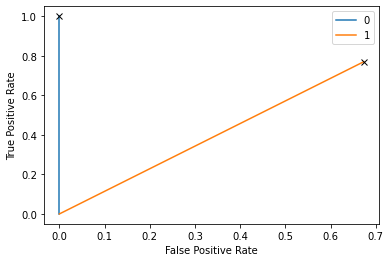

In [113]:
taus, roc = attr_ROC_curves(clf, X_train, A_train, y_train)

for a in roc.keys():
    fp = [x[0] for x in roc[a]]
    tp = [x[1] for x in roc[a]]
    
    plt.plot(fp, tp, label=a)
    ix = np.argmin(np.abs(taus-y_train.mean())) # decision threshold
    plt.plot(fp[ix], tp[ix], 'kx')
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

## A new idea for fair classification

After a blissfully uninterrupted afternoon of data science, your colleague bursts back into your office with a new and improved method:

"It's obvious that the best way to achieve fairness is to fit a model to each group - by minimizing the train error for each group separately, we guarantee that each group gets the best performance possible!" 

In [114]:
class DefinitelyFairModel:
    def __init__(self, clf):
        self.base_clf = clf
        self.predictors = {}
    
    def fit(self, X, y, A):
        '''
        Train a model for each sub-group in A
        '''
        for a in np.unique(A):
            Xa = X[A==a]
            ya = y[A==a]
            clf = copy.copy(self.base_clf)
            self.predictors[a] = clf.fit(Xa, ya)
            
    def predict(self, X, A):
        preds = np.zeros(X.shape[0])
        for a in np.unique(A):
            preds[A==a] = self.predictors[a].predict(X[A==a])
        return preds
    
    def predict_proba(self, X, A):
        probs = np.zeros((X.shape[0], 2)) # 2 since its binary ?
        for a in np.unique(A):
            probs[A==a] = self.predictors[a].predict_proba(X[A==a])
        return probs

Again, they claim that this new method demonstrates high accuracy. 

In [115]:
clf = LogisticRegression(C=1e-2, max_iter=250)

dfm = DefinitelyFairModel(clf)
dfm.fit(X_train, y_train, A_train)

## Finding C

The testset should be used to predict the performance of the model for `DefinitelyFairModel`

In [116]:
# preds = dfm.predict(X_train, A_train) #Finding C: mistake
test_preds = dfm.predict(X_test, A_test) #Finding C: correction
train_preds = dfm.predict(X_train, A_train)
r2_score(y_test, test_preds)

0.7548665027085243

And not only does it achieve high accuracy, but it also seems to have excellent performance on each subgroup:

In [117]:
def precision(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    prec = tp / (tp + fp)
    return prec

def recall(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    rec = tp / (tp + fn)
    return rec
def tpr(y_true, y_pred):
    TPR = recall(y_true, y_pred)
    return TPR

def fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    FPR = fp / (fp + tn)
    return FPR

In [118]:
def attr_ROC_curves(cls, X, A, Y_true, Y_pred, tau_range = np.linspace(0,1,51)):
    curves = {}
    all_probs = cls.predict_proba(X, A)[:, 1]
    for a in np.unique(A):
        curves[a] = []
        prob_a = all_probs[A==a]
        Ya = Y_true[A==a]
        for t in tau_range:
            pred = prob_a > t
            # curves[a] += [(np.mean(pred[Ya==0]), np.mean(pred[Ya==1]))] 
            curves[a] += [(fpr(Ya, pred), tpr(Ya, pred))] 
    return tau_range, curves

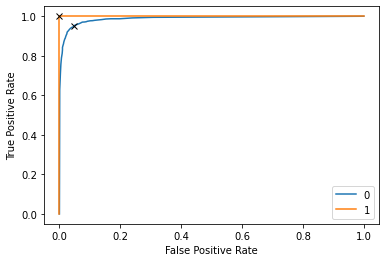

In [119]:
taus, roc = attr_ROC_curves(dfm, X_train, A_train, y_train, train_preds)

for a in roc.keys():
    fp = [x[0] for x in roc[a]]
    tp = [x[1] for x in roc[a]]
    
    plt.plot(fp, tp, label=a)
    ix = np.argmin(np.abs(taus-y_train.mean())) # decision threshold
    plt.plot(fp[ix], tp[ix], 'kx')
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

## Finding F

In [120]:
dpt = demo_parity_table(test_preds, A_test)
dpt

,0,1
P(f(X)=1 | A=a),0.430119,0.779221
P(f(X)=1),0.457000,0.457000


In [121]:
# equalized_odds_difference(y_train, preds, sensitive_features=A_train)
equalized_odds_difference(y_test, test_preds, sensitive_features=A_test)

0.05009633911368015

What do you think of the `DefinitelyFairClassifier`?

Here the model peforms badly for demographic parity. This is because since a new model has been trained for each sub-group in the data, there is no consistiency accross the whole set of predictions. 

As can be seen, the equalized odds performs very well.

Overall, the model is slightly better than the first classifier

## A new state-of-the-art method in fair ML?

Your colleague concludes with a final claim: "There's no way to train a logistic regression model that beats my `DefinitelyFairClassifier` - it dominates all the rest in terms of fairness and accuracy. I even went through the MSR `fairlearn` package, and their method doesn't even come close. I'm going to be up to my eyeballs in job offers with my new state-of-the-art method!"

They justify this claim with the following analysis:

In [122]:
from fairlearn.reductions import GridSearch, EqualizedOdds

In [123]:
model = LogisticRegression(C=1e-2, max_iter=250) # same base model as in `DefinitelyFairClassifier`

sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=7,
                  grid_limit=0.5)

sweep.fit(X_train, y_train, sensitive_features=A_train)

In [124]:
# compute scores, predictions, and fairness / accuracy metrics for each model in the sweep
sweep_preds = [predictor.predict(X_train) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(X_train)[:, 1] for predictor in sweep.predictors_]

equalized_odds_sweep = [
    equalized_odds_difference(y_train, preds, sensitive_features=A_train)
    for preds in sweep_preds
]
auc_sweep = [roc_auc_score(y_train, scores) for scores in sweep_scores]

all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": auc_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

In [125]:
# get comparable results for the DFC
train_preds = dfm.predict(X_train, A_train)
train_scores = dfm.predict_proba(X_train, A_train)

dfm_auc = roc_auc_score(y_train, train_scores[:,1])
dfm_eod = equalized_odds_difference(y_train, train_preds, sensitive_features=A_train)

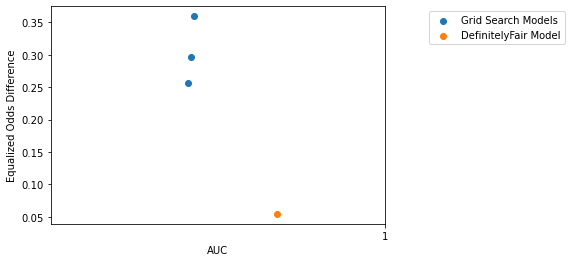

In [126]:
# plot results 
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="Grid Search Models")
plt.scatter(dfm_auc, dfm_eod, label="DefinitelyFair Model")

plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.xlim([0.97,1])
plt.xticks([1.0])
plt.show()